In [7]:

import pandas as pd
import os
from scipy.interpolate import interp1d
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from matplotlib import pyplot as plt
import networkx as nx

In [8]:
path = r"datasets\\datasets_data\\collected\\"


In [9]:
xlsx = []
csv = []

#ignored: ecodata, air_condition

def read(name,date_key='时间',date_format = None):
    sheet = pd.read_csv(os.path.join(path,name))
    sheet[date_key] = pd.to_datetime(sheet[date_key],format=date_format)
    sheet.rename(columns={date_key:'date'},inplace=True)
    sheet = sheet.set_index('date')
    return sheet

# xlsx.append[([pd.read_excel(os.path.join(path,'carbon_emission.xlsx'))],'emission vector')]

csv.append(read('air_pollution_events.csv'))
csv.append(read('citylize.csv'))
csv.append(read('comsume.csv','时间?'))
csv.append(read('energy_investment.csv'))
csv.append(read('energy_structure.csv','时间?'))
csv.append(read('medic_insurance.csv'))
csv.append(read('thick_cause_death.csv','时间?'))
csv.append(read('work_time.csv'))

csvs = pd.concat(csv,axis=1)

csvs.to_csv(os.path.join(path,'processed','summarize.csv'))

In [10]:

# 读取summarize.csv
df = pd.read_csv(r'datasets\datasets_data\collected\processed\summarize.csv')
# 将'date'列转换为datetime类型
df['date'] = pd.to_datetime(df['date'])

# 检查数据质量
print("数据形状:", df.shape)
print("数据类型:\n", df.dtypes)
print("缺失值检查:\n", df.isnull().sum())

# 缺失值处理
# 删除'date'列中有缺失值的行
df.dropna(subset=['date'], inplace=True)

# '城乡居民比例'等比例类指标用前后均值填充
ratio_cols = ['城乡居民比例']
df[ratio_cols] = df[ratio_cols].fillna(method='ffill').fillna(method='bfill')

# 人口、经济相关指标用二次样条插值
pop_eco_cols = ['乡村人口数:年', '城镇人口数:年', '农村家庭平均每人年消费性支出:年?', 
                '城镇居民人均可支配收入:财产净收入:年?', '城镇居民人均消费性支出:年?', 
                '农村居民人均可支配收入_全国_年?', '能源生产总量:年?','一次能源生产量:年?']
for col in pop_eco_cols:
    df[col] = df[col].interpolate(method='spline', order=2)
    df[col] = df[col].fillna(df[col].mean())

# 其他列用均值填充
other_cols = df.columns.difference(['date'] + ratio_cols + pop_eco_cols)
df[other_cols] = df[other_cols].fillna(df[other_cols].mean())

# 异常值检查与处理
print("异常值检查-五数概括:\n", df.describe())
# 假设'人均能源生产量:年?'列的异常值为大于1000的值
df.loc[df['人均能源生产量:年?'] > 1000, '人均能源生产量:年?'] = 1000  

# 根据variable_choosel中的变量,从summarize.csv中提取相关指标
# 个人层面变量
df['个人收入'] = df['城镇居民人均可支配收入:财产净收入:年?']  # 直接取'城镇居民人均可支配收入:财产净收入:年?'列
df['个人健康'] = 100 - df['城市呼吸系统疾病粗死亡率_当期值_年?']  # 用100减去'城市呼吸系统疾病粗死亡率_当期值_年?',得到个人健康指标

# 微观层面变量
df['环境污染'] = df['大气污染事故次数:年']  # 直接取'大气污染事故次数:年'列
df['能源利用'] = df['能源生产总量:年?'] / df['一次能源生产量:年?']  # '能源生产总量:年?'除以'一次能源生产量:年?',得到能源利用指标

# 中观层面变量 
df['环保投资'] = df['固定资产投资额(不含农户):电力、热力、燃气及水生产和供应业:能源工业:上海市:年'] + df['固定资产投资额(不含农户):能源工业:上海市:年']  # 对两列求和,得到环保投资指标
df['技术水平'] = df['技术市场成交合同金额:能源生产、分配和合理利用:年?']  # 直接取'技术市场成交合同金额:能源生产、分配和合理利用:年?'列

# 宏观层面变量
df['经济发展'] = df['全国一般公共预算支出决算数_医疗卫生与计划生育支出_公共卫生_疾病预防控制机构_当期值_年?'] + df['全国一般公共预算支出决算数_医疗卫生与计划生育支出_医疗保障_疾病应急救助_当期值_年?']  # 对两列求和,得到经济发展指标
df['人口结构'] = df['城乡居民比例']  # 直接取'城乡居民比例'列

# 只保留所需变量
variables = ['date', '个人收入','个人健康','环境污染','能源利用','环保投资','技术水平','经济发展','人口结构'] 
df = df[variables]

# 将数据类型转换为float
df[variables[1:]] = df[variables[1:]].astype(float)

# 将'date'列设置为索引
df.set_index('date', inplace=True)

# 数据标准化
df = (df - df.min()) / (df.max() - df.min())

print("预处理后的数据:\n", df.head())
df.to_csv(os.path.join(path,'processed',"data_preprocessed.csv"))  # 保存预处理后的数据

数据形状: (234, 261)
数据类型:
 date                                              datetime64[ns]
大气污染事故次数:西藏自治区:年                                         float64
大气污染事故次数:年                                               float64
大气污染事故次数:宁夏回族自治区:年                                       float64
大气污染事故次数:甘肃省:年                                           float64
                                                       ...      
专科疾病防治院(所、站)床位数_新疆维吾尔自治区_年?                              float64
全国一般公共预算支出决算数_医疗卫生与计划生育支出_公共卫生_疾病预防控制机构_当期值_年?           float64
全国一般公共预算支出决算数_医疗卫生与计划生育支出_医疗保障_疾病应急救助_当期值_年?             float64
就业人员周平均工作时间:当期值:月                                        float64
BLS就业形势报告:私营非农就业人员:平均每周工作时间:季调:当期值:月                     float64
Length: 261, dtype: object
缺失值检查:
 date                                                0
大气污染事故次数:西藏自治区:年                                  232
大气污染事故次数:年                                        214
大气污染事故次数:宁夏回族自治区:年                                223
大气污染事故次数:甘

C:\Users\19920\AppData\Local\Temp\ipykernel_17296\248815811.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[ratio_cols] = df[ratio_cols].fillna(method='ffill').fillna(method='bfill')


异常值检查-五数概括:
                                 date  大气污染事故次数:西藏自治区:年  大气污染事故次数:年  \
count                            234        234.000000  234.000000   
mean   2005-12-01 10:52:18.461538432          2.500000  568.100000   
min              1949-12-31 00:00:00          0.000000  130.000000   
25%              2006-05-07 18:00:00          2.500000  568.100000   
50%              2011-03-15 12:00:00          2.500000  568.100000   
75%              2019-05-23 06:00:00          2.500000  568.100000   
max              2024-03-31 00:00:00          5.000000  986.000000   
std                              NaN          0.231621   80.469486   

       大气污染事故次数:宁夏回族自治区:年  大气污染事故次数:甘肃省:年  大气污染事故次数:陕西省:年  大气污染事故次数:云南省:年  \
count          234.000000      234.000000      234.000000      234.000000   
mean             2.454545       16.625000       13.866667       37.266667   
min              1.000000        3.000000        3.000000        1.000000   
25%              2.454545       16.625000       

C:\Users\19920\AppData\Local\Temp\ipykernel_17296\248815811.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['个人收入'] = df['城镇居民人均可支配收入:财产净收入:年?']  # 直接取'城镇居民人均可支配收入:财产净收入:年?'列
C:\Users\19920\AppData\Local\Temp\ipykernel_17296\248815811.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['个人健康'] = 100 - df['城市呼吸系统疾病粗死亡率_当期值_年?']  # 用100减去'城市呼吸系统疾病粗死亡率_当期值_年?',得到个人健康指标
C:\Users\19920\AppData\Local\Temp\ipykernel_17296\248815811.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

c:\Users\19920\scoop\apps\anaconda3\current\App\envs\ai_models\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\19920\scoop\apps\anaconda3\current\App\envs\ai_models\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\19920\scoop\apps\anaconda3\current\App\envs\ai_models\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\19920\scoop\apps\anaconda3\current\App\envs\ai_models\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\19920\scoop\apps\anaconda3\current\App\envs\ai_models\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated sin

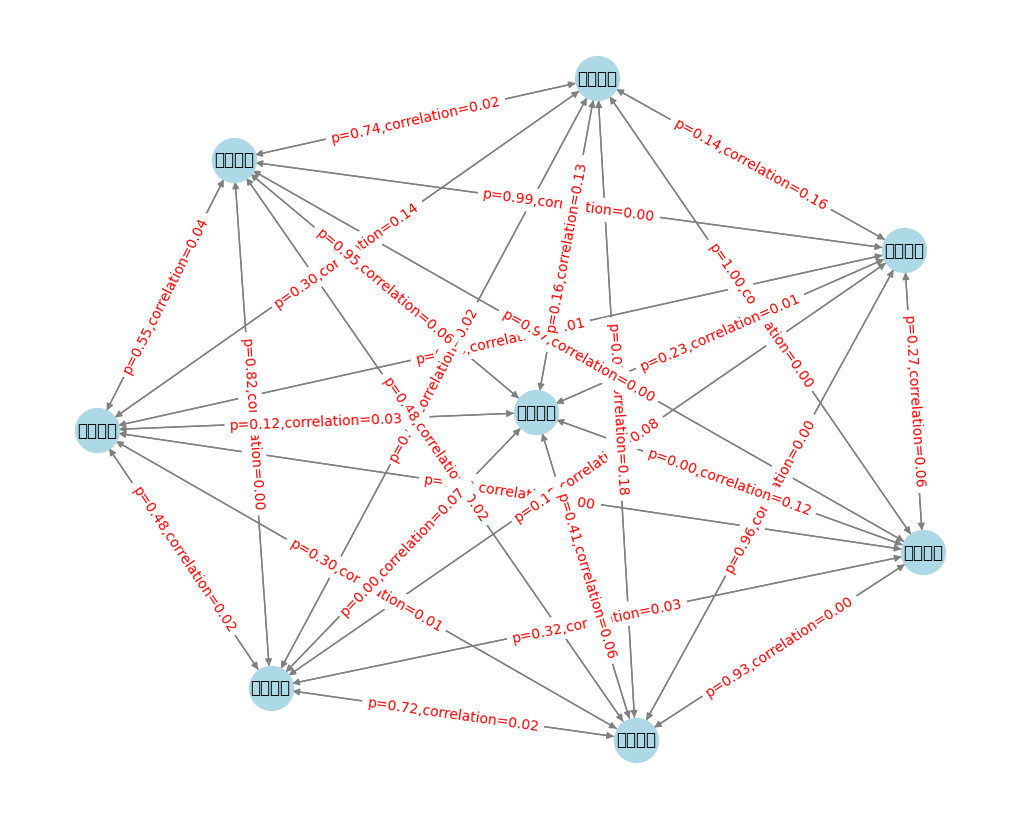

In [11]:
# 读取预处理后的数据
df = pd.read_csv(os.path.join(path,'processed',"data_preprocessed.csv"), index_col='date', parse_dates=['date'])

# 定义变量列表
variables = ['个人收入', '个人健康', '环境污染', '能源利用', '环保投资', '技术水平', '经济发展', '人口结构']

# Granger因果检验
maxlag = 2  # 设置最大时滞
test_results = pd.DataFrame(np.zeros((len(variables), len(variables))),
                            index=variables, columns=variables)
for cause in variables:
    for effect in variables:
        if cause != effect:
            test = grangercausalitytests(list(df[[cause, effect]].dropna().values), maxlag=maxlag, verbose=False)
            p_values = [test[i+1][0]['ssr_ftest'][1] for i in range(maxlag)]
            min_p_value = np.min(p_values)
            test_results.loc[cause, effect] = min_p_value

# 交叉相关分析
lags = range(1, 11)  # 设置时滞范围
cross_corr = pd.DataFrame(index=variables, columns=variables)
for cause in variables:
    for effect in variables:
        if cause != effect:
            cross_corr.loc[cause, effect] = df[cause].shift(1).corr(df[effect])

# 绘制有向无环图(DAG)
G = nx.DiGraph()
G.add_nodes_from(variables)
edge_labels = {}  # 用于存储边标签

# 添加边
for cause in variables:
    for effect in variables:
        if cause != effect:
            # if test_results.loc[cause, effect] < 0.5 and abs(cross_corr.loc[cause, effect]) > 0.2:
            G.add_edge(cause, effect)
            edge_labels[(cause, effect)] = f"p={test_results.loc[cause, effect]:.2f},correlation={abs(cross_corr.loc[cause, effect]):.2f}"

# 绘制DAG
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_size=12, node_size=1000)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.axis('off')
plt.show()

#TODO 美化一下

In [17]:
#todo re make the model
import os
import pandas as pd
import semopy


# 读取预处理后的数据
data = pd.read_csv(os.path.join(path, 'processed', 'data_preprocessed.csv'), index_col='date', parse_dates=['date'])

paths = {
    'Individual': ['个人收入', '个人健康'],
    'Micro': ['环境污染', '能源利用'],
    'mEso': ['环保投资', '技术水平'],
    'macroDynamic': ['经济发展', '人口结构']
}

# 标准化数据
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)

# 定义变量
variables = list(scaled_data.columns)

# 创建模型
model_desc = ""
for latent_var, observed_vars in paths.items():
    for observed_var in observed_vars:
        model_desc += f"{latent_var} =~ {observed_var}\n"

model_desc += "Individual ~~ Micro\n"
model_desc += "Micro ~~ mEso\n"
model_desc += "mEso ~~ marcoDynamic\n"

# 修正模型描述字符串格式
model = semopy.Model(model_desc)

model.fit(scaled_data)

stats = semopy.calc_stats(model)
print(stats.T)
g = semopy.semplot(model, os.path.join("article","figures","sem_model.png"))

ValueError: 'mEso' is not in list